# Analys of Referenced Files in Bug Tickets
In this study we want to analyze the file referenced by developers while discussing about bugs to improve SZZ performances. By their discussion we could address two different problems:
1. Extrinsic Bugs: the fix and the bug does not share any file, but the developer might have talked about the fix-inducing files in the ticket. In this case, SZZ can take the latest modification of such files before the ticket submission.
2. Noise Reduction: not all the files in the bug-fixing commits are responsible of the fix. Moreover, not necessarily all the modified files are responsible for the bug. SZZ has big issues in terms of precision, since it produces too many results compared to the bug scope. Reducing the set of input files for SZZ, we could increase the precision of the algorithm. To this extent, we want to limit SZZ execution to modified files that appear in the bug discussion.

In [1]:
from bugbug import db, bugzilla, repository

from os import path
import re
import similarity_checker
import filepath_miner
import json
import pandas as pd
import matplotlib.pyplot as plt

import logging
from tqdm import tqdm

import nltk
from nltk.corpus import brown
from nltk.corpus import stopwords

LOGGER = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

assert db.download(bugzilla.BUGS_DB)
assert db.download(repository.COMMITS_DB)
assert nltk.download('brown')
assert nltk.download('stopwords')
bot_filenames = ['uplift_beta.py',
                 'needinfo_regression_author.py',
                 'firefox-source-docs.mozilla.org/bug-mgmt/guides/bug-types.html',
                 'fuzzing_bisection_without_regressed_by.py',
                 'close_intermittents.py',
                 'workflow.2Fno_severity.py']

2023-10-13 18:29:29,780:INFO:bugbug.db:Downloading https://community-tc.services.mozilla.com/api/index/v1/task/project.bugbug.data_bugs.latest/artifacts/public/bugs.json.zst to data/bugs.json.zst
data/bugs.json.zst  : 2300142052 bytes 
2023-10-13 18:30:16,511:INFO:bugbug.db:Downloading https://community-tc.services.mozilla.com/api/index/v1/task/project.bugbug.data_commits.latest/artifacts/public/commits.json.zst to data/commits.json.zst
data/commits.json.zst: 9732903724 bytes 
[nltk_data] Downloading package brown to /Users/poojarani/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/poojarani/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
fixes = set()
reference_dict = dict()
code_reference_dict = dict()
fix_bug_id_map = dict()
valid = re.compile(r".*[A-Za-z0-9]+[.][A-Za-z]+$")
fix_counter = 0
referred_counter = 0
bug_map = dict()
buggy_ids = set()
pr_map = dict()
full_data = list()
set_words = set(brown.words())
set_stopwords = set(stopwords.words('english'))
curr_moz_filepaths = filepath_miner.file_dict('mozilla-unified')
with open('filenames_history.json', 'r+') as json_file:
    moz_filepaths = json.load(json_file)

for key, value in curr_moz_filepaths.items():
    if key not in moz_filepaths:
        moz_filepaths.setdefault(key, list()).extend(value)
    else:
        for el in value:
            if el not in moz_filepaths[key]:
                moz_filepaths[key].append(el)

json_file.close()

0it [00:00, ?it/s]


In [3]:
for bug in tqdm(bugzilla.get_bugs()):
    if bug['regressed_by'] and not bug['is_open'] and bug['resolution'] == "FIXED" :
        fix_counter += 1
        referenced_files = set()
        code_references = set()
        all_words = set()
        for comment in bug['comments']:
            content = comment['text']
            all_words = all_words.union(set(content.replace('\n', ' ').replace('\t', ' ').replace('\'', ' ').replace('"', ' ').replace('(', ' ').replace(')', ' ').replace('[', ' ').replace(']', ' ').replace('{', ' ').replace('}', ' ').replace(':', ' ').replace(',', ' ').replace(';', ' ').replace('|', ' ').replace('!', ' ').replace('?', ' ').replace('\t', ' ').replace('//', ' ').replace(' /', ' ').replace('#', ' ').replace('. ', ' ').split(' ')))

        clean_words = set()
        words = [token for token in all_words if token not in set_stopwords]

        for word in words:
            new_word = word
            if new_word.startswith('--'):
                continue

            if new_word:
                if new_word[-1] in ('.', ';', ',','[', ']', '(', ')', '{', '}'):
                    new_word = new_word[:-1]

            if new_word and len(new_word) > 1:
                clean_words.add(new_word)

        reference_words = [el for el in clean_words if el not in set_words and el not in set_stopwords]

        for el in reference_words:
            if valid.match(el) and el not in bot_filenames:
                extension = el.split('.')[-1]
                root = el.split('.')[0]
                if extension in ['cpp', 'h', 'js', 'ini', 'cc', 'rs', 'html', 'build',
                                 'py', 'jsm', 'txt', 'java', 'css', 'c', 'json', 'yml',
                                 'gn', 'toml', 'md', 'list', 'yaml', 'idl', 'mm', 'xhtml',
                                 'xml', 'sh', 'rst', 'in', 'webidl']:
                    if ':' not in el and root != 'wiki':
                        referenced_files.add(el)

            else:
                if ':' not in el:
                    if any([char in ['-', '_'] for char in el]) or (any([str(char).isupper() for char in el[1:-1]]) and el[0].islower()) or el.isupper():
                        code_references.add(el)

        if referenced_files:
            referred_counter += 1

        reference_dict.setdefault(bug['id'], list()).extend(referenced_files)
        code_reference_dict.setdefault(bug['id'], list()).extend(code_references)
        fixes.add(bug['id'])

        for bug_id in bug['regressed_by']:
            fix_bug_id_map.setdefault(bug['id'], set()).add(bug_id)


    if bug['regressions']:
        buggy_ids.add(bug['id'])

197339it [00:38, 5077.95it/s] 


In [4]:
extensions = list()
for commit in tqdm(repository.get_commits()):
    if commit['bug_id'] and commit['bug_id'] in fixes or commit['bug_id'] in buggy_ids:
        for filename in commit['files']:
            pr_map.setdefault(commit['bug_id'], set()).add(filename)
            extensions.append(filename.split('.')[-1])


577255it [00:43, 13393.97it/s]


In [5]:
for key, values in tqdm(reference_dict.items()):
    reference = dict()
    modified_files = list()
    code_references = list()

    if key in pr_map:
        modified_files = list(pr_map[key])

    if key in code_reference_dict:
        code_references = code_reference_dict[key]

    reference['fix_id'] = key                                   # id of the fix
    reference['modified_files'] = modified_files                # file modified in the fix
    reference['referenced_files'] = values                      # file referenced in the bug discussion
    reference['reference_counter'] = len(values)                # number of referenced file in bug discussion
    reference['referenced_code_elements'] = code_references     # references to code elements
    parsed_references = list()

    for file_path in modified_files:
        highest_sim = 0
        parsed_filename = None
        for file_reference in values:
            new_sim = similarity_checker.end_root_similarity(file_path, file_reference)
            if new_sim >= 0.8 and new_sim > highest_sim:
                highest_sim = new_sim
                parsed_filename = file_path

            elif new_sim == 1:
                parsed_filename = file_path
                continue

        if parsed_filename is not None:
            parsed_references.append(parsed_filename)

    reference['parsed_references'] = parsed_references          #  file referenced in the issue converted in file modified since path similarity
    reference['parsed_counter'] = len(parsed_references)        #  counter of files referenced in the issue parsed in modified files

    reference['bug_ids'] = fix_bug_id_map[key]      # ids of the bugs associated to the fix

    bug_files = list()
    if fix_bug_id_map[key]:
        for bug_id in fix_bug_id_map[key]:
            if bug_id in pr_map:
                bug_files.extend(list(pr_map[bug_id]))

    reference['bug_files'] = list(set(bug_files))           # files associated to the bug

    parsed_bug_references = list()

    for file_path in set(bug_files):
        highest_sim = 0
        parsed_filename = None
        for file_reference in values:
            new_sim = similarity_checker.end_root_similarity(file_path, file_reference)
            if new_sim >= 0.8 and new_sim > highest_sim:
                highest_sim = new_sim
                parsed_filename = file_path

            elif new_sim == 1:
                parsed_filename = file_path
                continue

        if parsed_filename is not None:
            parsed_bug_references.append(parsed_filename)

    reference['parsed_bug_references'] = parsed_bug_references          #  file referenced in the issue converted in buggy files since path similarity
    reference['parsed_bug_counter'] = len(parsed_bug_references)        #  counter of files referenced in the issue parsed into buggy files
    strict_repo_references = list()
    relaxed_repo_references = list()
    has_duplicates = False
    for file_reference in values:
        filename = file_reference.split('/')[-1]
        if filename in moz_filepaths:
            highest_sim = 0
            parsed_filename = None
            duplicate = False
            duplicate_dict = dict()
            for filepath in moz_filepaths[filename]:
                new_sim = similarity_checker.end_root_similarity(filepath, file_reference)
                if new_sim > 0.8 and new_sim > highest_sim:
                    parsed_filename = filepath
                    highest_sim = new_sim

                if new_sim == 1 and new_sim == highest_sim:
                    duplicate = True
                    duplicate_dict.setdefault(filename, set()).add(parsed_filename)
                    duplicate_dict[filename].add(filepath)

            if duplicate:
                for file_name in duplicate_dict.keys():
                    max_sim = 0
                    to_add = None
                    for file_path in duplicate_dict[file_name]:
                        for file_ref in modified_files:
                            local_sim = similarity_checker.end_root_similarity(file_path, file_ref)
                            if local_sim > max_sim:
                                to_add = '/'.join(file_path.split('/')[1:])
                                max_sim = local_sim

                    if to_add is not None and max_sim > 0.5:
                        relaxed_repo_references.append(to_add)

            elif not duplicate and parsed_filename is not None:
                parsed_filename = '/'.join(parsed_filename.split('/')[1:])
                strict_repo_references.append(parsed_filename)


            has_duplicates = has_duplicates or duplicate

        #else:
            #logging.info(f'Missing: file {file_reference} not in current repo version. Path not retrievable')

    strict_repo_references = list(set(strict_repo_references))
    relaxed_repo_references = list(set(relaxed_repo_references))

    reference['strict_repo_references'] = strict_repo_references            # file referenced in the issue converted in a file of the repository based on path similarity
    reference['strict_repo_counter'] = len(strict_repo_references)          # counter of files referenced in the issue and referenced into a file of the repository

    reference['relaxed_repo_references'] = relaxed_repo_references          # file referenced in the issue converted in a file of the repository based on path similarity with modified files
    reference['relaxed_repo_counter'] = len(relaxed_repo_references)        # counter of file referenced in the issue converted in a file of the repository based on path similarity with modified files
    reference['has_duplicates_repo_reference'] = has_duplicates

    reference['fix_reference_shared'] = len(set(modified_files).intersection(set(reference['referenced_files'])))           # files shared between fix and discussion
    reference['bug_reference_shared'] = len(set(bug_files).intersection(set(reference['referenced_files'])))                # files shared between bug and discussion

    reference['fix_fixsim_reference_shared'] = len(set(modified_files).intersection(set(reference['parsed_references'])))       # files shared between fix and discussion after fix parsing
    reference['bug_fixsim_reference_shared'] = len(set(bug_files).intersection(set(reference['parsed_references'])))            # files shared between bug and discussion after fix parsing

    reference['fix_bugsim_reference_shared'] = len(set(modified_files).intersection(set(reference['parsed_bug_references'])))       # files shared between fix and discussion after bug parsing
    reference['bug_bugsim_reference_shared'] = len(set(bug_files).intersection(set(reference['parsed_bug_references'])))            # files shared between bug and discussion after bug parsing


    reference['has_references'] = True if reference['reference_counter'] > 0 else False

    # A reference is valuable if it appears in either the bug or the fix commits
    reference['has_valuable_reference'] = True if (reference['parsed_counter'] > 0 or reference['parsed_bug_counter'] > 0) else False

    # A strict reference is a reference with an exact match in the repository, and it is valuable if it appears in either the bug of the fix commits
    reference['has_strict_repo_valuable_reference'] = True if (set(reference['strict_repo_references']).intersection(set(reference['parsed_references'])) or
                                                    set(reference['strict_repo_references']).intersection(set(reference['parsed_bug_references']))) else False

    # A relaxed reference is a reference with an partial match in the repository, and it is valuable if it appears in either the bug of the fix commits
    reference['has_relaxed_repo_valuable_reference'] = True if (set(reference['relaxed_repo_references']).intersection(set(reference['parsed_references'])) or
                                                    set(reference['relaxed_repo_references']).intersection(set(reference['parsed_bug_references']))) else False


    extrinsic_reference = False
    extrinsic_bug = False
    if not set(reference['modified_files']).intersection(set(reference['bug_files'])):
        extrinsic_bug = True
        if reference['bug_reference_shared'] > 0 or reference['bug_bugsim_reference_shared'] > 0 or reference['bug_fixsim_reference_shared'] > 0:
            extrinsic_reference = True

    reference['extrinsic_bug'] = extrinsic_bug                  # the bug is extrinsic
    reference['extrinsic_reference'] = extrinsic_reference      # the bug is extrinsic but there is a reference usable to link it

    included_subset = False
    same_set = False
    if len(reference['referenced_files']) > 0:
        if reference['fix_reference_shared'] > 0 or reference['fix_fixsim_reference_shared'] > 0 or reference['fix_bugsim_reference_shared'] > 0:
                included_subset = True
                if reference['fix_reference_shared'] == len(reference['modified_files']) or reference['fix_fixsim_reference_shared'] == len(reference['modified_files']) or reference['fix_bugsim_reference_shared'] == len(reference['modified_files']):
                    same_set = True

    reference['included_subset'] = included_subset      # the fix has some files discussed in the bug ticket
    reference['same_set'] = same_set                    # the fix has the same file discussed in the bug ticket
    reference['reduced_noise'] = True if included_subset and not same_set else False

    linkable = True if set(bug_files).intersection(set(modified_files)) else False
    reference['is_linkable'] = linkable         # the fix and the bug shares at least one file

    ref_linkable = True if linkable or (not linkable and extrinsic_reference) else False
    reference['is_linkable_with_ref'] = ref_linkable    # the fix and the bug are linkable if also using the reference



    full_data.append(reference)

full_data_pd = pd.DataFrame(full_data)
full_data_pd.to_csv(path.join('full_data.csv'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13921/13921 [03:08<00:00, 73.88it/s]


In [ ]:
full_data_pd

# How many bug tickets contain file references?

In [ ]:
referenced = full_data_pd['has_references'].value_counts()
referenced_norm = full_data_pd['has_references'].value_counts(normalize=True)
referenced_df = pd.concat([referenced, referenced_norm], axis=1)
referenced_df.columns = ['count', 'norm']
referenced_df['cum_perc'] = referenced_df['norm'].cumsum()*100

In [ ]:
referenced_df

# How many bug tickets contain a reference that can be used to refine SZZ?

In [ ]:
valuable_referenced = full_data_pd['has_valuable_reference'].value_counts()
valuable_referenced_norm = full_data_pd['has_valuable_reference'].value_counts(normalize=True)
valuable_referenced_df = pd.concat([valuable_referenced, valuable_referenced_norm], axis=1)
valuable_referenced_df.columns = ['count', 'norm']
valuable_referenced_df['cum_perc'] = valuable_referenced_df['norm'].cumsum()*100

In [ ]:
valuable_referenced_df

# How many bug tickets contains a valuable reference that can be parsed to Mozilla's file and used to refine SZZ?

In [ ]:
valuable_repo_referenced = full_data_pd['has_relaxed_repo_valuable_reference'].value_counts()
valuable_repo_referenced_norm = full_data_pd['has_relaxed_repo_valuable_reference'].value_counts(normalize=True)
valuable_repo_referenced_df = pd.concat([valuable_repo_referenced, valuable_repo_referenced_norm], axis=1)
valuable_repo_referenced_df.columns = ['count', 'norm']
valuable_repo_referenced_df['cum_perc'] = valuable_referenced_df['norm'].cumsum()*100

In [ ]:
valuable_repo_referenced_df

# How many bugs can be linked by SZZ?

In [ ]:
linkable = full_data_pd['is_linkable'].value_counts()
linkable_norm = full_data_pd['is_linkable'].value_counts(normalize=True)
linkable_df = pd.concat([linkable, linkable_norm], axis=1)
linkable_df.columns = ['count', 'norm']
linkable_df['cum_perc'] = linkable_df['norm'].cumsum()*100

In [ ]:
linkable_df

# How many bugs can be linked by SZZ adding file references?

In [ ]:
linkable_ref = full_data_pd['is_linkable_with_ref'].value_counts()
linkable_ref_norm = full_data_pd['is_linkable_with_ref'].value_counts(normalize=True)
linkable_ref_df = pd.concat([linkable_ref, linkable_ref_norm], axis=1)
linkable_ref_df.columns = ['count', 'norm']
linkable_ref_df['cum_perc'] = linkable_ref_df['norm'].cumsum()*100

In [ ]:
linkable_ref_df

# How many bugs can be detangled?

In [ ]:
noise_ref = full_data_pd['reduced_noise'].value_counts()
noise_ref_norm = full_data_pd['reduced_noise'].value_counts(normalize=True)
noise_ref_df = pd.concat([noise_ref, noise_ref_norm], axis=1)
noise_ref_df.columns = ['count', 'norm']
noise_ref_df['cum_perc'] = noise_ref_df['norm'].cumsum()*100

In [ ]:
noise_ref_df

# How many extrinsic bug can be detected by discussion files?

In [ ]:
bug_references = full_data_pd['extrinsic_reference'].value_counts()
bug_references_norm = full_data_pd['extrinsic_reference'].value_counts(normalize=True)
bug_references_df = pd.concat([bug_references, bug_references_norm], axis=1)
bug_references_df.columns = ['count', 'norm']
bug_references_df['cum_perc'] = bug_references_df['norm'].cumsum()*100

In [ ]:
bug_references_df

# How many references to fix files are in tickets?

In [ ]:
ref_pd = full_data_pd.copy()
ref_pd = ref_pd.loc[ref_pd['parsed_counter'] > 0]
fix_references_box = ref_pd.boxplot('parsed_counter', showfliers=False)
plt.show()

# How many references to bug files are in tickes?

In [ ]:
bug_ref_pd = full_data_pd.copy()
bug_ref_pd = bug_ref_pd.loc[bug_ref_pd['parsed_bug_counter'] > 0]
bug_references_box = bug_ref_pd.boxplot('parsed_bug_counter', showfliers=False)
plt.show()

# How many references can be parsed into Mozilla's file

In [ ]:
repo_ref_pd = full_data_pd.copy()
repo_ref_pd = repo_ref_pd.loc[repo_ref_pd['relaxed_repo_counter'] > 0]
repo_references_box = repo_ref_pd.boxplot('relaxed_repo_counter', showfliers=False)
plt.show()

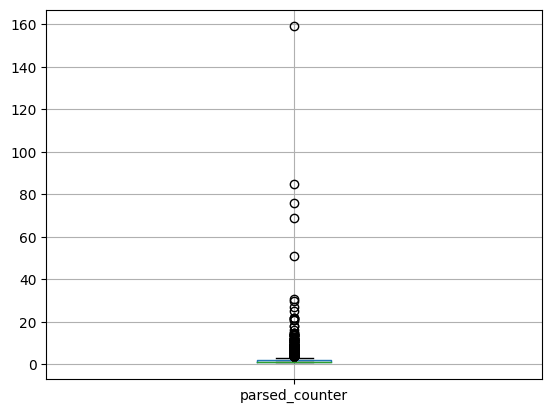

In [165]:
ref_pd = full_data_pd.copy()
ref_pd = ref_pd.loc[ref_pd['parsed_counter'] > 0]
fix_references_box = ref_pd.boxplot('parsed_counter', showfliers=False)
plt.show()

# How many references to bug files are in tickes?

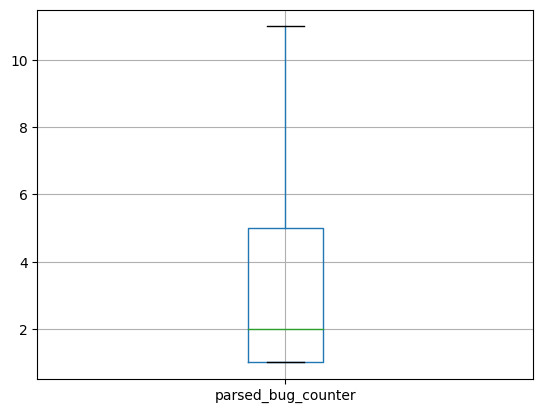

In [166]:
bug_ref_pd = full_data_pd.copy()
bug_ref_pd = bug_ref_pd.loc[bug_ref_pd['parsed_bug_counter'] > 0]
bug_references_box = bug_ref_pd.boxplot('parsed_bug_counter', showfliers=False)
plt.show()

# How many references can be parsed into Mozilla's file

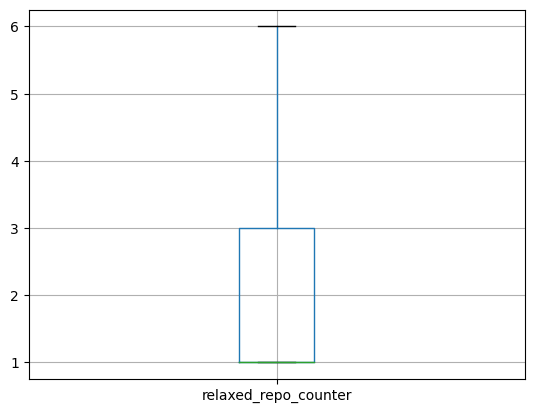

In [167]:
repo_ref_pd = full_data_pd.copy()
repo_ref_pd = repo_ref_pd.loc[repo_ref_pd['relaxed_repo_counter'] > 0]
repo_references_box = repo_ref_pd.boxplot('relaxed_repo_counter', showfliers=False)
plt.show()

In [171]:
extrinsic_bug = full_data_pd.copy()
extrinsic_bug = extrinsic_bug.loc[extrinsic_bug['extrinsic_reference'] == True]

In [172]:
extrinsic_bug

,fix_id,modified_files,referenced_files,reference_counter,referenced_code_elements,parsed_references,parsed_counter,bug_ids,bug_files,parsed_bug_references,...,has_valuable_reference,has_strict_repo_valuable_reference,has_relaxed_repo_valuable_reference,extrinsic_bug,extrinsic_reference,included_subset,same_set,reduced_noise,is_linkable,is_linkable_with_ref
6,1472626,[browser/modules/FaviconLoader.jsm],"[webglsamples.org/aquarium/aquarium.html, modu...",5,[sentry.prod.mozaws.net/operations/nightly-js-...,[],0,{1453751},[toolkit/components/extensions/test/mochitest/...,[browser/base/content/browser.js],...,True,False,False,True,True,False,False,False,False,True
22,1556119,[js/src/shell/js.cpp],"[js/src/shell/js.cpp, js/src/vm/Interpreter.cp...",3,"[js_arena_malloc, home/ubuntu/shell-cache/js-6...",[js/src/shell/js.cpp],1,{1290287},"[js/src/vm/HelperThreads.h, js/src/vm/PosixNSP...","[js/src/vm/HelperThreads.h, js/src/vm/PosixNSP...",...,True,False,False,True,True,True,True,False,False,True
23,1556220,[js/src/jit/CacheIR.cpp],"[js/src/jit/IonCacheIRCompiler.cpp, js/src/jit...",3,"[ionScript=0x7fd80c3fe000, arrayType=js, store...",[js/src/jit/CacheIR.cpp],1,{1456569},"[js/src/vm/CommonPropertyNames.h, js/src/tests...","[js/src/jit/IonTypes.h, js/src/jit/MacroAssemb...",...,True,False,False,True,True,True,True,False,False,True
28,1562146,"[js/src/jit-test/tests/fields/bug1562146.js, j...",[builds/worker/workspace/build/src/js/src/jit-...,19,[hg.mozilla.org/mozilla-central/rev/27f0cd20a8...,"[js/src/jit-test/tests/fields/bug1562146.js, j...",2,{1529772},"[js/src/tests/jstests.list, js/src/jit-test/te...","[js/src/jit-test/tests/fields/error.js, js/src...",...,True,False,True,True,True,True,True,False,False,True
32,1564012,[js/src/jit-test/tests/debug/bug-1564012.js],"[js/src/gc/Tracer.cpp, home/ubuntu/shell-cache...",5,"[doTrace, dispatchToOnEdge, newCompartment, ne...",[js/src/jit-test/tests/debug/bug-1564012.js],1,{1560754},"[js/src/jit-test/tests/debug/bug1557343-2.js, ...",[js/src/jit-test/tests/debug/bug1557343-2.js],...,True,False,False,True,True,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12415,1797999,[testing/web-platform/meta/fetch/orb/tentative...,[fetch/orb/tentative/img-mime-types-coverage.t...,1,"[06.239Z, Content-Type, ORB, 06.181Z, assert_u...",[],0,{1785331},[netwerk/test/unit_ipc/test_orb_empty_header_w...,[testing/web-platform/tests/fetch/orb/tentativ...,...,True,False,True,True,True,False,False,False,False,True
12427,1799252,[],[usr/src/debug/gtk3-3.24.34-2.fc37.x86_64/gdk/...,6,"[bp-a56bba93-fac0-41c1-8408-7eee10221105, wl_d...",[],0,{1796130},"[widget/gtk/WaylandVsyncSource.cpp, widget/gtk...","[widget/gtk/WaylandVsyncSource.cpp, widget/gtk...",...,True,False,False,True,True,False,False,False,False,True
12431,1799569,[testing/web-platform/meta/css/css-contain/con...,[hg.mozilla.org/mozilla-central/raw-file/tip/l...,4,"[MOZ_LOG=signaling, 23.375Z, treeherder.mozill...",[testing/web-platform/meta/css/css-contain/con...,1,{1797424},[testing/web-platform/meta/xhr/xmlhttprequest-...,[testing/web-platform/meta/css/css-contain/con...,...,True,False,False,True,True,True,True,False,False,True
12438,1800494,[testing/mozbase/mozlog/mozlog/formatters/mach...,[mochitests/content/a11y/accessible/tests/moch...,9,"[self._format_status, INFO, needinfo_regressio...",[testing/mozbase/mozlog/mozlog/formatters/mach...,1,{1744340},[third_party/python/blessings/blessings-1.7.di...,[third_party/python/blessed/blessed/colorspace...,...,True,False,False,True,True,True,True,False,False,True
